In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from src.utils.preprocess import *
from src.utils.generate_operating_condition import *
from src.utils.config import *
from src.models.model import *
from src.utils.util import *

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [2]:
input_path="./dataset/processed/input/"
output_path="./dataset/processed/output/"
boundary_no_obs_path=input_path+"cnn_input/no_obstacle/"
label_no_obs_path=output_path+"no_obstacle/"
boundary_yes_obs_path=input_path+"cnn_input/yes_obstacle/"
label_yes_obs_path=output_path+"yes_obstacle/"
operating_total_path=input_path+"text_input/total/"

## 1. 데이터구성

#### 데이터로드

In [3]:
boundary_data_no_obs=np.load(boundary_no_obs_path+'boundary_condition.npy')
label_data_no_obs=np.load(label_no_obs_path+'temperature_label.npy')

boundary_data_yes_obs=np.load(boundary_yes_obs_path+'boundary_condition.npy')
label_data_yes_obs=np.load(label_yes_obs_path+'temperature_label.npy')

operating_data_total=np.load(operating_total_path+'operating_condition.npy')

In [4]:
boundary_data = np.concatenate([boundary_data_no_obs,boundary_data_yes_obs],axis=0)
label_data = np.concatenate([label_data_no_obs,label_data_yes_obs],axis=0)
boundary_data.shape, operating_data_total.shape, label_data.shape

((423, 460800), (423, 10), (423, 120, 60, 64))

#### 데이터전처리

In [5]:
simul_config = simulaion_config()
x_dim = simul_config.x_dim
y_dim = simul_config.y_dim
z_dim = simul_config.z_dim

In [6]:
# 공간정보 데이터
boundary_data_s = []
for i in boundary_data:
    i=i.reshape(x_dim,y_dim,z_dim,1)
    boundary_data_s.append(i)
boundary_data = np.array(boundary_data_s).astype("float64")
boundary_data.shape

(423, 120, 60, 64, 1)

In [7]:
# 운전정보 데이터
char2idx,idx2char=generate_total_operating_data()
temporary_data=operating_division(operating_data_total,idx2char)
operating_config=operating_condition_max_value_config(temporary_data)
temporary_data=operating_scaling(temporary_data,operating_config)

special_token=[]
special_value=[]
for i in range(len(temporary_data)):
    special_token.append(temporary_data[:,0][i])
    special_value.append(temporary_data[:,1][i])
special_token=np.array(special_token)
special_value=np.array(special_value)

## 제거대상(임시)

In [8]:
# boundary_data_temp = boundary_data.copy()
# special_token_temp = special_token.copy()
# special_value_temp = special_value.copy()
# label_data_temp = label_data.copy()

# boundary_data = []
# special_token = []
# special_value = []
# label_data = []

# for i,j,k,z in zip(boundary_data_temp,special_token_temp,special_value_temp,label_data_temp):
    
#     # 입구온도 10 벽온도 30 일때만 담음
#     if (k[1]==0.2) and (k[2]==0.6) :
#         boundary_data.append(i)
#         special_token.append(j)
#         special_value.append(k)
#         label_data.append(z)
#     else:
#         pass

# boundary_data = np.array(boundary_data)
# special_token = np.array(special_token)
# special_value = np.array(special_value)
# label_data = np.array(label_data)

# boundary_data.shape, special_token.shape, special_value.shape, label_data.shape

In [9]:
# 레이블 데이터
max_label = np.max(label_data)
min_label = np.min(label_data)

label_data = (label_data-min_label)/(max_label-min_label)
np.max(label_data), np.min(label_data)

(1.0, 0.0)

#### 데이터분할

In [10]:
train_ratio = 0.75
valid_ratio = 0.15
test_ratio = 0.10
first_split_size=1-train_ratio
second_split_size=test_ratio/(test_ratio+valid_ratio)

cnn_train, cnn_tv, label_train, label_tv = train_test_split(boundary_data, label_data, test_size=first_split_size, random_state=42)
cnn_val, cnn_test, label_val, label_test = train_test_split(cnn_tv, label_tv, test_size=second_split_size, random_state=42)
spe_tok_train, spe_tok_tv, val_tok_train, val_tok_tv = train_test_split(special_token, special_value, test_size=first_split_size, random_state=42)
spe_tok_val, spe_tok_test, val_tok_val, val_tok_test = train_test_split(spe_tok_tv, val_tok_tv, test_size=second_split_size, random_state=42)

#### 데이터구성

In [11]:
X_train = [cnn_train, spe_tok_train, val_tok_train]
X_test = [cnn_test, spe_tok_test, val_tok_test]
X_val = [cnn_val, spe_tok_val, val_tok_val]
Y_train = label_train
Y_test = label_test
Y_val = label_val
print("X_train ",X_train[0].shape)
print("X_val ",X_val[0].shape)
print("X_test ",X_test[0].shape)
print("Y_train ",Y_train.shape)
print("Y_val ",Y_val.shape)
print("Y_test ",Y_test.shape,'\n')

X_train  (317, 120, 60, 64, 1)
X_val  (63, 120, 60, 64, 1)
X_test  (43, 120, 60, 64, 1)
Y_train  (317, 120, 60, 64)
Y_val  (63, 120, 60, 64)
Y_test  (43, 120, 60, 64) 



In [12]:
cnn_test.shape,spe_tok_test.shape,val_tok_test.shape

((43, 120, 60, 64, 1), (43, 5), (43, 5))

---

## 2. 모델구성

#### 모델정의

In [13]:
model_config=get_transformer_config()

In [14]:
model=CFDUnet(model_config)

#### 모델 컴파일

In [15]:
def L2_loss(y_true,y_pred):
    error = tf.math.square(y_true-y_pred)
    loss = tf.reduce_sum(error)
    return loss

In [16]:
initial_learning_rate = 1e-5

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

model.compile(
    # loss=L2_loss,
    loss='mae',
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["mae","mse"],
)

#### 모델 경로지정

In [17]:
# 모델 저장 경로정의
WEIGHT_PATH = 'checkpoints/'
model_name = 'transUnet/'
test_num = 'total2'
TEST_DIR = 'TEST' + str(test_num) + '/'
# 경로지정
checkpoint_path = WEIGHT_PATH + model_name + TEST_DIR + "TEST" + str(test_num)
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

checkpoints/transUnet/TESTtotal2 -- Folder already exists 



#### callback 함수 지정

In [18]:
# EarlyStopping
earlystop_callback = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=20)

# Tensorboard
log_dir = "logs/fit/" + 'TEST' + str(test_num) + "" 

if os.path.exists(log_dir):
    print("{} -- Folder already exists \n".format(log_dir))
else:
    os.makedirs(log_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(log_dir))
    
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# checkpoint
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

logs/fit/TESTtotal2 -- Folder already exists 



---

## 3. 학습

In [19]:
model.load_weights(checkpoint_path)

In [20]:
BATCH_SIZE = 1

In [21]:
history = model.fit(X_train, Y_train, 
                      validation_data=(X_val,Y_val),
                      batch_size=BATCH_SIZE, epochs=1500,
                      callbacks=[earlystop_callback, cp_callback, tensorboard_callback])

Epoch 1/1500
317/317 [==============================] - 108s 276ms/step - loss: 0.0256 - mae: 0.0256 - mse: 0.0016 - val_loss: 0.0254 - val_mae: 0.0254 - val_mse: 0.0014

Epoch 00001: val_loss improved from inf to 0.02537, saving model to checkpoints/transUnet/TESTtotal2\TESTtotal2
Epoch 2/1500
317/317 [==============================] - 87s 273ms/step - loss: 0.0238 - mae: 0.0238 - mse: 0.0013 - val_loss: 0.0284 - val_mae: 0.0284 - val_mse: 0.0015

Epoch 00002: val_loss did not improve from 0.02537
Epoch 3/1500
317/317 [==============================] - 87s 273ms/step - loss: 0.0265 - mae: 0.0265 - mse: 0.0014 - val_loss: 0.0242 - val_mae: 0.0242 - val_mse: 0.0013

Epoch 00003: val_loss improved from 0.02537 to 0.02421, saving model to checkpoints/transUnet/TESTtotal2\TESTtotal2
Epoch 4/1500
317/317 [==============================] - 87s 272ms/step - loss: 0.0261 - mae: 0.0261 - mse: 0.0015 - val_loss: 0.0232 - val_mae: 0.0232 - val_mse: 0.0013

Epoch 00004: val_loss improved from 0.02

## 4. 학습결과 확인

In [22]:
%load_ext tensorboard 

In [23]:
%tensorboard --logdir logs/fit --host localhost --port 6012

---

## 5. 테스트

In [23]:
checkpoint_path

'checkpoints/transUnet/TEST8/TEST8'

In [24]:
model.load_weights(checkpoint_path)

In [25]:
prediction = model.predict(X_test,batch_size=1)

#### 역스케일링 및 차원통일

In [26]:
for num in range(len(prediction)):
    prediction[num]=(prediction[num]*(max_label-min_label)+min_label)
    Y_test[num]=(Y_test[num]*(max_label-min_label)+min_label)

prediction=np.squeeze(prediction)  
Y_test=np.squeeze(Y_test) 
print(prediction.shape)
print(Y_test.shape)

(11, 120, 60, 64)
(11, 120, 60, 64)


#### 플로팅 1) scatter

In [27]:
# 플로팅시 사용될 데이터프레임 
def plus_info_dataframe(lst,obs):
    lst = np.arange(0,len(lst),1)
    lst = list(map(lambda x:obs+"_"+str(x)+".csv",lst))
    return lst

csv_lst = os.listdir("dataset/dataframe/yes_obstacle/")
csv_lst = plus_info_dataframe(csv_lst,"yes")

# 데이터프레임 분할
df_train, df_tv = train_test_split(csv_lst, test_size=first_split_size, random_state=42)
df_val, df_test = train_test_split(df_tv, test_size=second_split_size, random_state=42)

# 시뮬레이션 운전조건 확인위한 데이터프레임
simulation_df_yes_obs = pd.read_csv("src/data/simulation/processed/yes_obstacle.csv")

장애물있는 데이터입니다.
========시뮬레이션 조건========
File name            Case380
inlet_velocity          1.91
inlet_temperature         10
wall_temperature          30
Angle                     70
Name: 79, dtype: object
======== 공간구조 확인 ========


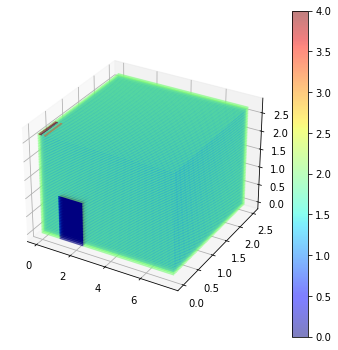

In [82]:
plot_num = 5
df = check_simulation_info(plot_num,df_test,None,simulation_df_yes_obs,cnn_test,geometry_plot=True)

In [83]:
pred_min = np.min(prediction[plot_num])
pred_max = np.max(prediction[plot_num])
Y_test_min = np.min(Y_test[plot_num])
Y_test_max = np.max(Y_test[plot_num])
plot_max = max(pred_max,Y_test_max)
plot_min = max(pred_min,Y_test_min)

Text(0.5, 0, 'z-dim')

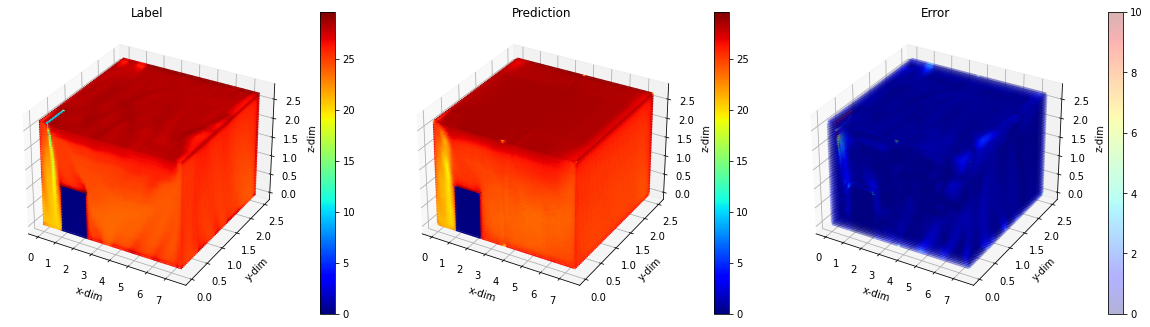

In [87]:
fig = plt.figure(figsize=(20,16))

# Label
ax = fig.add_subplot(131, projection='3d')
plt.title('Label')
im=ax.scatter(df['x'], df['y'], df['z'], c=Y_test[plot_num], s=0.5, alpha=1, cmap='jet', vmin=plot_min, vmax=plot_max)
plt.colorbar(im, fraction=0.046, pad=0.1)
ax.set_xlabel("x-dim")
ax.set_ylabel("y-dim")
ax.set_zlabel("z-dim")

# Prediction
ax = fig.add_subplot(132, projection='3d')
plt.title('Prediction')
im=ax.scatter(df['x'], df['y'], df['z'], c=prediction[plot_num], s=0.5, alpha=1, cmap='jet', vmin=plot_min, vmax=plot_max)
plt.colorbar(im, fraction=0.046, pad=0.1)
# plt.colorbar(im, fraction=0.046, pad=0.1, location='bottom')
ax.set_xlabel("x-dim")
ax.set_ylabel("y-dim")
ax.set_zlabel("z-dim")

# Error
ax = fig.add_subplot(133, projection='3d')
plt.title('Error')
error=abs((Y_test[plot_num]-prediction[plot_num]))
im=ax.scatter(df['x'], df['y'], df['z'], c=error, s=0.5, alpha=0.3, cmap='jet', vmin=0, vmax=10)
plt.colorbar(im, fraction=0.046, pad=0.1)
# plt.colorbar(im, fraction=0.046, pad=0.1, location='bottom')
ax.set_xlabel("x-dim")
ax.set_ylabel("y-dim")
ax.set_zlabel("z-dim")

#### 플로팅 2) pyvista

In [88]:
plot_num = 5 
df = check_simulation_info(plot_num,df_test,None,simulation_df_yes_obs,cnn_test,geometry_plot=False)

장애물있는 데이터입니다.
========시뮬레이션 조건========
File name            Case380
inlet_velocity          1.91
inlet_temperature         10
wall_temperature          30
Angle                     70
Name: 79, dtype: object


In [89]:
pred_min = np.min(prediction[plot_num])
pred_max = np.max(prediction[plot_num])
Y_test_min = np.min(Y_test[plot_num])
Y_test_max = np.max(Y_test[plot_num])
plot_max = max(pred_max,Y_test_max)
plot_min = max(pred_min,Y_test_min)

In [90]:
# 레이블
opt_list=[1,28,7,0.5,plot_min,plot_max]
plot=Y_test[plot_num].reshape(x_dim*y_dim*z_dim)
array_list=[df["x"].values,df["y"].values,df["z"].values]
pyvista_plot(plot,opt_list,array_list)

In [91]:
# Prediction
opt_list=[1,28,7,0.5,plot_min,plot_max]
plot=prediction[plot_num].reshape(x_dim*y_dim*z_dim)
array_list=[df["x"].values,df["y"].values,df["z"].values]
pyvista_plot(plot,opt_list,array_list)

---

## 6. 성능검증

### 분석1. 회귀선

In [34]:
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.metrics import mean_squared_error

num = 1
y_label = Y_test[num].reshape(x_dim*y_dim*z_dim)
y_pre = prediction[num].reshape(x_dim*y_dim*z_dim)
print(f"레이블 최소 : {np.min(y_label)} 레이블 최대 : {np.max(y_label)}")
print(f"예측값 최소 : {np.min(y_pre)} 예측값 최대 : {np.max(y_pre)}")

레이블 최소 : 0.0 레이블 최대 : 29.49114380000003
예측값 최소 : -1.230863094329834 예측값 최대 : 29.562564849853516


In [35]:
r2_scores = []
rmse_lst = []
for num in range(len(Y_test)):
    r2_label = Y_test[num].reshape(x_dim*y_dim*z_dim)
    r2_pred = prediction[num].reshape(x_dim*y_dim*z_dim)
    r2_scores.append(r2_score(r2_label,r2_pred))
    rmse = np.sqrt(mean_squared_error(r2_label,r2_pred))
    rmse_lst.append(rmse)
print(f" R2 score 평균점수 : {np.average(r2_scores)}")
print(f" RMSE 평균 : {np.average(rmse_lst)}")

 R2 score 평균점수 : 0.9859463968459113
 RMSE 평균 : 0.5394430849821649


기본 데이터 값에 대한 회귀선 플롯

<Figure size 864x720 with 0 Axes>

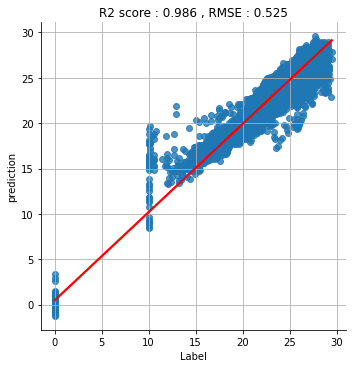

In [36]:
reg_df = pd.DataFrame({"label":y_label,"prediction":y_pre})
r2score = np.round(r2_score(y_label,y_pre),3)
rmse = np.round(np.sqrt(mean_squared_error(y_label,y_pre)),3)

plt.figure(figsize=[12,10])
ax = sns.lmplot(x="label", y="prediction", data=reg_df, line_kws = {'color' : 'red'})
plt.xlabel("Label")
plt.ylabel("prediction")
plt.title(f"R2 score : {r2score} , RMSE : {rmse}")
plt.grid()

특정부분 제외한 데이터에 대해 회귀선 플롯

<Figure size 864x720 with 0 Axes>

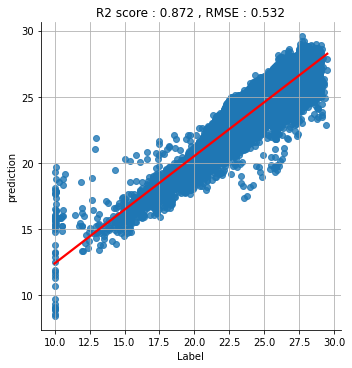

In [37]:
reg_df_ignore = reg_df[(reg_df["label"]>=5) & (reg_df["prediction"]>=5)]
r2score = np.round(r2_score(reg_df_ignore["label"],reg_df_ignore["prediction"]),3)
rmse = np.round(np.sqrt(mean_squared_error(reg_df_ignore["label"],reg_df_ignore["prediction"])),3)

plt.figure(figsize=[12,10])
ax = sns.lmplot(x="label", y="prediction", data=reg_df_ignore, line_kws = {'color' : 'red'})
plt.xlabel("Label")
plt.ylabel("prediction")
plt.title(f"R2 score : {r2score} , RMSE : {rmse}")
plt.grid()

### 분석2. 단면확인 

장애물있는 데이터입니다.
========시뮬레이션 조건========
File name            Case377
inlet_velocity          1.91
inlet_temperature         10
wall_temperature          30
Angle                     50
Name: 76, dtype: object
======== 공간구조 확인 ========


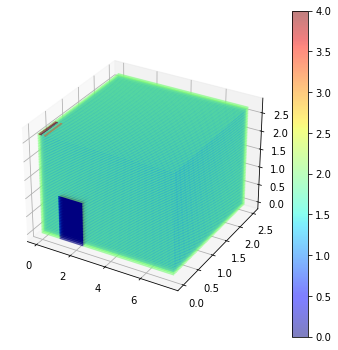

In [38]:
plot_num = 7
df = check_simulation_info(plot_num,df_test,None,simulation_df_yes_obs,cnn_test,geometry_plot=True)

In [39]:
df["prediction"]=prediction[plot_num].reshape(x_dim*y_dim*z_dim)
df["label"]=Y_test[plot_num].reshape(x_dim*y_dim*z_dim)

position_y = 0
default_y = sorted(list(set(df["y"]))) # 고정될 y값 (xz 단면을 보기위해)
condition_y = df["y"]==default_y[position_y] # y 조건 정의
x = df[condition_y]["x"]
z = df[condition_y]["z"]
pred = df[condition_y]["prediction"]
label = df[condition_y]["label"]

vmax_value = max(np.max(label),np.max(pred))
vmin_value = min(np.min(label),np.min(pred))
vmax_value,vmin_value

(29.49746090000002, -0.58602726)

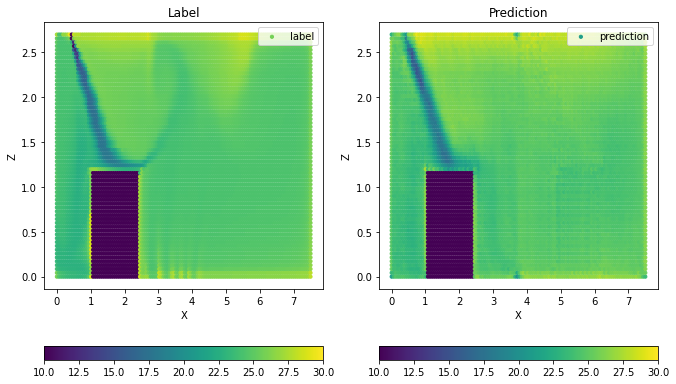

In [47]:
plt.figure(figsize=[11,7])
plt.subplot(1,2,1)
plt.scatter(x,z,c=label,marker="o",s=10, label="label", vmin=10, vmax=30)
plt.xlabel("X")
plt.ylabel("Z")
plt.title("Label")
plt.legend()
plt.colorbar(location='bottom')

plt.subplot(1,2,2)
plt.scatter(x,z,c=pred, marker="o",s=10, label="prediction", vmin=10, vmax=30)
plt.xlabel("X")
plt.ylabel("Z")
plt.title("Prediction")
plt.legend()
plt.colorbar(location='bottom')

### 분석3. 라인확인 
- 위에서 정의한 단면에 대해 라인별로 확인

Text(0, 0.5, 'Value')

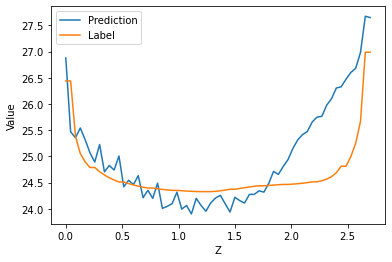

In [48]:
# y고정
position_y = 0
default_y = sorted(list(set(df["y"]))) # 고정될 y값 (xz 단면을 보기위해)
condition_y = (df["y"]==default_y[position_y]) # y 조건 정의
x = df[condition_y]["x"]

# x고정
position_x = 102
default_x = sorted(list(set(x)))
condition_x = (df["x"]==default_x[position_x])

# z값과 plot할 대상
z = df[condition_x & condition_y]["z"]
pred = df[condition_x & condition_y]["prediction"]
label = df[condition_x & condition_y]["label"]

# plot
plt.plot(z,pred,label="Prediction")
plt.plot(z,label,label='Label')
plt.legend()
plt.xlabel("Z")
plt.ylabel("Value")

## 7. Interpolation & Extrapolation - 운전조건

#### 주의 : 전체데이터(장애물O)를 사용한다.
- 장애물있는 데이터경우 사용된 값 목록
- 입구속도 : 1.43 1.91 2.38
- 입구온도 : 10 고정
- 벽온도 : 30 고정
- 각도 : 30 50 70

(0) 비교하기 위한 조건별 레이블 데이터 로드

In [70]:
# [기준] 레이블 역스케일링
Y_IE_label = label_data.copy()

for i in range(len(Y_IE_label)):
    Y_IE_label[i]=(Y_IE_label[i]*(max_label-min_label)+min_label)

In [71]:
plot_num = 5

# 전체데이터 사용하기위해 df은 csv_lst 사용 (분할전 데이터프레임)
df = check_simulation_info(plot_num,csv_lst,None,simulation_df_yes_obs,boundary_data,geometry_plot=False)

장애물있는 데이터입니다.
========시뮬레이션 조건========
File name            Case306
inlet_velocity          2.38
inlet_temperature         10
wall_temperature          30
Angle                     50
Name: 5, dtype: object


(1) 내삽외삽 위한 데이터 생성

In [72]:
# 데이터생성
IE_boundary=boundary_data[plot_num:plot_num+1] 
IE_spe_tok=special_token[plot_num:plot_num+1]

# 입구속도 입구온도 벽온도 각도 None 
IE_spc_val=np.array([1.43, 10, 30, 90, 0.])
IE_spc_val=scaling_for_IE_ploation(IE_spc_val,driving_config)

# 데이터구성
X_IE_polation=[IE_boundary,IE_spe_tok,IE_spc_val]

# 예측
Y_IE_polation=model.predict(X_IE_polation,batch_size=1)

# 예측값 역스케일링
for i in range(len(Y_IE_polation)):
    Y_IE_polation[i]=(Y_IE_polation[i]*(max_label-min_label)+min_label)

np.max(Y_IE_polation), np.min(Y_IE_polation)

(32.172974, -2.0727415)

(2) 각도변경 테스트

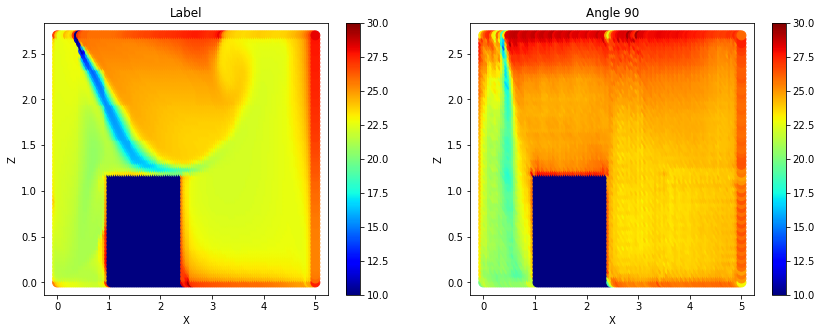

In [74]:
## 단면으로 결과확인 (y 좌표값 고정)

df["label"]=Y_IE_label[plot_num].reshape(x_dim*y_dim*z_dim)
df["prediction"]=Y_IE_polation.reshape(x_dim*y_dim*z_dim)

position_y = 0
default_y = sorted(list(set(df["y"]))) # 고정될 y값 (xz 단면을 보기위해)
condition_y = df["y"]==default_y[position_y] # y 조건 정의
x = df[condition_y]["x"]
z = df[condition_y]["z"]
label = df[condition_y]["label"]
pred = df[condition_y]["prediction"]

plt.figure(figsize=[14,5])
plt.subplot(1,2,1)
plt.scatter(x,z,c=label, marker="o", s=80, cmap='jet', label="Label", vmin=10, vmax=30)
plt.xlabel("X")
plt.ylabel("Z")
plt.title("Label")

plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(x,z,c=pred, marker="o", s=80, cmap='jet', label="prediction", vmin=10, vmax=30)
plt.xlabel("X")
plt.ylabel("Z")
plt.title("Angle 90")
plt.colorbar()

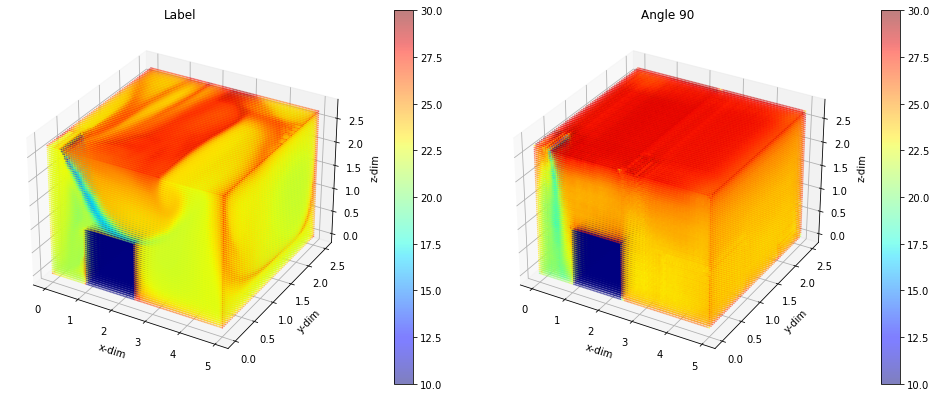

In [76]:
## Scatter 로 결과확인

fig = plt.figure(figsize=(16,12))

ax = fig.add_subplot(121, projection='3d')
im = ax.scatter3D(df["x"],df["y"],df["z"],zdir='z', c=Y_IE_label[plot_num], cmap='jet', s=0.5, alpha=0.5, vmin=10, vmax=30)
plt.title("Label")
ax.set_xlabel("x-dim")
ax.set_ylabel("y-dim")
ax.set_zlabel("z-dim")
plt.colorbar(im, fraction=0.046, pad=0.1)

ax = fig.add_subplot(122, projection='3d')
im = ax.scatter3D(df["x"],df["y"],df["z"], zdir='z', c=Y_IE_polation, cmap='jet', s=0.5, alpha=0.5, vmin=10, vmax=30)
plt.title("Angle 90")
ax.set_xlabel("x-dim")
ax.set_ylabel("y-dim")
ax.set_zlabel("z-dim")
plt.colorbar(im, fraction=0.046, pad=0.1)

## 8. Interpolation & Extrapolation - 공간조건

공간조건 데이터 생성

In [ ]:
from src.utils.generate_obstacle_data import *
from src.utils.generate_boundary_condition import *

In [ ]:
obstacle_data = {
    # 시뮬레이션 고정값
    "x_dim":120,
    "y_dim":60,
    "z_dim":64,
    "x_max":5,
    "y_max":2.5,
    "z_max":2.7,

    # 장애물 개수 설정
    "obs_count":5,

    # 장애물 위치 좌표값 지정 (아래값은 마지막에 사용했던 실내공간 좌표값)
    "obs_x_min":[1, 1, 1, 4, 0.8], 
    "obs_x_max":[2.5, 3, 3, 4.3, 2.7],
    "obs_y_min":[0, 1.85, 2.35, 0, 0.2],
    "obs_y_max":[0.7, 2.5, 2.5, 1.5, 0.5],
    "obs_z_min":[0, 0, 0.3, 0, 0.7],
    "obs_z_max":[0.7, 0.3, 0.8, 2.5, 1.6],
    
    # 입구/출구 좌표값
    "input_pos": [0.3798,0.4548,0,0.466,2.7,2.7],
    "output_pos": [0.044,0.1898,0,0.466,2.7,2.7],

    ## <참고>
    # 테이블(LG 기본) : 1,2.5,0,1,0,1.2
    # 소파(LG 기본) : (1) 1,3,1.85,2.5,0,0.3 
    #                 (2) 1,3,2.35,2.5,0.3,0.8
}

In [ ]:
obstacle_config = get_obstacle_config(obstacle_data)
obstacle_df = make_null_dataframe(obstacle_config)
obstacle_arr = generate_obstacle_data(obstacle_config)

temp = 1 
for i in obstacle_arr:
    temp = temp*i
obstacle_arr = temp

obstacle_df["value"]=obstacle_arr
obstacle_df = make_bdr(obstacle_df,obstacle_config.input_pos,obstacle_config.output_pos)
obstacle_df["value"] = obstacle_df["value"] * obstacle_df["Boundary"]

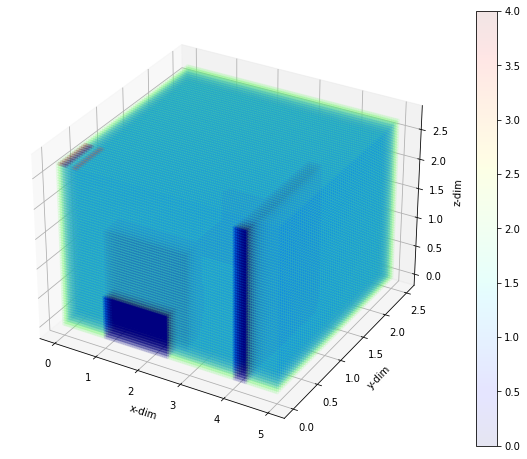

In [ ]:
plotting(obstacle_df,obstacle_df["value"],[12,8,10,0.1,0,4,30,300])

데이터 생성

In [ ]:
# 공간데이터
IE_boundary=np.array(obstacle_df["value"].values).reshape(1,120,60,64,1)

# 운전데이터
IE_spe_tok=special_token[0:1]
IE_spc_val=np.array([1.43, 10, 30, 50, 0.]) # 입구속도 입구온도 벽온도 각도 None 
IE_spc_val=scaling_for_IE_ploation(IE_spc_val,driving_config)

# 데이터구성
X_IE_polation=[IE_boundary,IE_spe_tok,IE_spc_val]

# 예측
Y_IE_polation=model.predict(X_IE_polation,batch_size=1)

# 예측값 역스케일링
for i in range(len(Y_IE_polation)):
    Y_IE_polation[i]=(Y_IE_polation[i]*(max_label-min_label)+min_label)

np.max(Y_IE_polation), np.min(Y_IE_polation)

(2.3462696, -0.075933434)

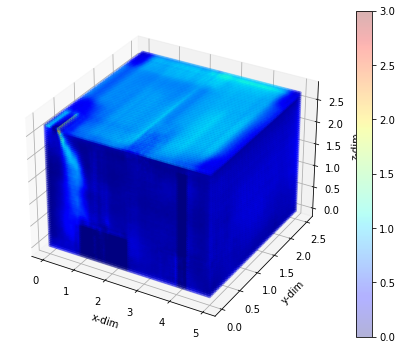

In [ ]:
## Scatter 로 결과확인
plotting(obstacle_df,Y_IE_polation,[8,6,5,0.3,0,3,30,300])

In [ ]:
# # Prediction
# opt_list=[0.4,3,10,0.5,0,3]
# plot=Y_IE_polation.reshape(x_dim*y_dim*z_dim)
# array_list=[obstacle_df["x"].values,obstacle_df["y"].values,obstacle_df["z"].values]
# pyvista_plot(plot,opt_list,array_list)

Text(0.5, 1.0, 'Prediction')

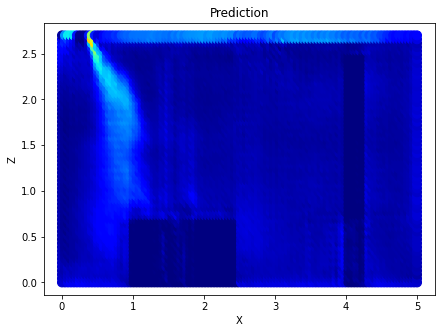

In [ ]:
## 단면으로 결과확인 (y 좌표값 고정)
obstacle_df["prediction"]=Y_IE_polation.reshape(x_dim*y_dim*z_dim)

# y좌표값 고정
position_y = 0
default_y = sorted(list(set(df["y"]))) # 고정될 y값 (xz 단면을 보기위해)
condition_y = df["y"]==default_y[position_y] # y 조건 정의
x = obstacle_df[condition_y]["x"]
z = obstacle_df[condition_y]["z"]
pred = obstacle_df[condition_y]["prediction"]

# 플로팅
plt.figure(figsize=[7,5])
plt.scatter(x,z,c=pred, marker="o", s=80, cmap='jet', label="Prediction", vmin=0, vmax=3)
plt.xlabel("X")
plt.ylabel("Z")
plt.title("Prediction")